# EE798 HW3
## Kutay Ugurlu

In [598]:
from scipy.linalg import toeplitz, dft, inv, eigvals, eig, kron, eigh
from scipy.signal import convolve2d, convolve
from sklearn.preprocessing import normalize
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2
import matplotlib.pyplot as plt
from skimage.data import camera 
from matplotlib.patches import Rectangle


# Q1 Matrix Representation of 2D Convolution 

## Q1 a

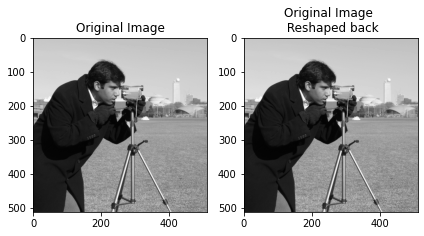

In [599]:
I = camera()
I_flatten = I.flatten(order="F")
I_back = np.reshape(I,(I.shape))
plt.subplot(1,2,1)
plt.imshow((I),cmap="gray")
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow((I_back),cmap="gray")
plt.title("Original Image \n Reshaped back")
plt.tight_layout()


### The vectors stacked in matrix H are flattened version of the convolved vectors of basis pixels. Since flattened basis vectors are lexicographically ordered, we observed shifted versions of block of the output vectors in the matrix, hence in a Toeplitz form. 

### This matrix may be too huge to store for a huge image size.

# Q1 b

### Given that H is of size $(P1,P2)$ and image of size $(N1,N2)$, FFT points of $$(N1+P1-1,N2+P2-1) = (L_1,L_2)$$ should be used to have [linear convolution](#linear_conv_cell).

### If FFT points $(N_1,N_2)$ are higher than the image sizes, the images are padded zeros until they have FFT points size, as in the case of linear convolution calculation. On the other hand, if we were to use fewer points FFT, then the images are rolled onto themselves in the following manner: $$\hat{x}(m,n) = \sum\limits_{i=-\infty}^{\infty}\sum\limits_{j=-\infty}^{\infty}x(m+N1i,n+N2j)$$ 

In [600]:
def cconv2(x:np.ndarray, y:np.ndarray,N1:int,N2:int):
    sizes = (N1,N2)
    return ifft2(np.multiply(fft2(x,sizes),fft2(y,sizes)))
    

### Tests

In [601]:
for _ in range(200):
    N1 = np.random.randint(1,5)
    N2 = np.random.randint(1,10)
    N3 = np.random.randint(1,20)
    x = np.random.randint(0,100,(N1,N1))
    y = np.random.randint(0,100,(N2,N3))
    cconv_size_1 = N1+N2-1
    cconv_size_2 = N1+N3-1
    res = convolve2d(x,y,mode="full")
    res2 = np.round(cconv2(y,x,cconv_size_1,cconv_size_2))
    assert np.sum(np.isclose(res,res2)) == res.size
print("All tests are success!")

All tests are success!


# Q1 c

In [602]:
def cconvmtx2(h:np.ndarray, image_shape, N1, N2):
    L1,L2 = image_shape
    H = np.empty((N1*N2,0))
    image_size = L1*L2
    for i in range(image_size):
        row = np.mod(i,L1)
        col = i//L1
        basis_vec = np.zeros((L1,L2))
        basis_vec[row,col] = 1
        basis_vec_output = cconv2(h,basis_vec,N1,N2)
        transformed_basis_vec = basis_vec_output.flatten(order="F")
        H = np.column_stack((H, transformed_basis_vec))
    return H 

## Verification

In [603]:
for trial in range(100):
    
    P1 =  np.random.randint(1,3)
    P2 =  np.random.randint(1,3)
    L1 = np.random.randint(P1,10)
    L2 = np.random.randint(P2,10)
    N1 = np.random.randint(L1,20)
    N2 = np.random.randint(L2,20)

    
    h = np.random.randint(1,5,(P1,P2))
    test_image = np.random.randint(1,100,(L1,L2))
    res = cconv2(h,test_image, N1, N2)
    H = cconvmtx2(h, test_image.shape, N1, N2)
    res2 = np.reshape(H.dot(test_image.flatten(order="F")),(N1,N2),order="F")
    assert np.sum(np.isclose(res,res2)) == res.size
    
print("All tests are success!")

All tests are success!


<a id='linear_conv_cell'></a>
## A linear convolution example $\downarrow$

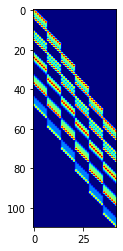

In [604]:
P1 =  np.random.randint(1,6)
P2 =  np.random.randint(1,6)
L1 = np.random.randint(P1,10)
L2 = np.random.randint(P2,10)
N1 = L1 + P1 - 1
N2 = L2 + P2 - 1


h = np.random.randint(1,5,(P1,P2))
test_image = np.random.randint(1,100,(L1,L2))
res = cconv2(h,test_image, N1, N2)
H = cconvmtx2(h, test_image.shape, N1, N2)
plt.imshow(np.real(H))

# Q1 d

In [605]:
def dftmtx2(N1:int, N2:int):
    F = np.empty((N1*N2,0))
    for i in range(N1*N2):
        row = np.mod(i,N1)
        col = i//N1
        basis_vec = np.zeros((N1,N2))
        basis_vec[row,col] = 1
        basis_vec_output = fft2(basis_vec,(N1,N2))
        transformed_basis_vec = basis_vec_output.flatten(order="F")
        F = np.column_stack((F, transformed_basis_vec))
    return F

## Verification 

### $(2DFFT(I))_{flat} == FI_{flat}$ ###

In [606]:
for trial in range(50):
    
    N1 = np.random.randint(1,20)
    N2 = np.random.randint(1,20)

    
    test_image = np.random.randint(1,100,(N1,N2))
    res = fft2(test_image, (N1, N2))
    F = dftmtx2(N1, N2)
    res2 = np.reshape(F.dot(test_image.flatten(order="F")),(N1,N2),order="F")
    F2 =  dftmtx2(N1, N1)
    assert np.sum(np.isclose(res,res2)) == res.size and np.sum(np.isclose(inv(F2),F2.conjugate().T/N1**2)) == F2.size
    
print("All tests are success!")

All tests are success!


### Since FFT matrix entries are symmetrical with respect to variables $n1$, $k1$ and $n2$, $k2$ the matrix is symmetric, _i.e._ $ F = F^T$. Inverse FFT matrix $F^{-1}$ have just conjugated entries scaled with $\frac{1}{N_1N_2}$ of F. Hence $F^{-1} = \frac{F^H}{N_1N_2}$ 

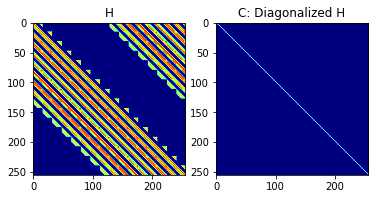

In [607]:
for _ in range(100):
    
    N = np.random.randint(2,20,(1,1)).item()
    P = np.random.randint(1,N,(1,1)).item()
    h = np.random.randint(40,100,(P,P))
    Image = np.random.randint(1,30,(N,N))
    H = cconvmtx2(h,Image.shape,N,N)
    h = np.pad(h,((0,N-P),(0,N-P)))
    F = dftmtx2(N,N)
    C = F.dot(H).dot(F.conjugate().T)/N**2
    diagC = np.diag(C)
    diagC_check = fft2(h,(N,N)).flatten(order="F")
    assert np.sum(np.isclose(diagC,diagC_check)) == diagC_check.size # Check whether diagonalized matrix stores the flattened FFT2 coefficients 
    x = Image.flatten(order="F")
    y = H.dot(x)
    Y = F.dot(y)
    H = F.dot(h.flatten(order="F"))
    X = F.dot(x)
    assert np.sum(np.isclose(Y,H*X)) == Y.size # Check whether the given relation is true 

H = cconvmtx2(h,Image.shape,N,N)
F = dftmtx2(N,N)
C = F.dot(H).dot(F.conjugate().T)/N**2
plt.subplot(1,2,1)
plt.imshow(np.real(H))
plt.title("H")
plt.subplot(1,2,2)
plt.imshow(np.abs(normalize(np.abs(C),norm="max")))
plt.title("C: Diagonalized H")
plt.show()


## $\mathbf{\tilde{C}}$ is a diagonal matrix storing the flattened version of 2D FFT coefficients of the filter. 
## $$diag(\mathbf{\tilde{C}}) = 2DFFT(H)_{flat}$$
## In addition, $\mathbf{\tilde{C}} = \frac{FHF^H}{N_1N_2}$ corresponds to the eigen decomposition of matrix H, hence diagonal matrix $\mathbf{\tilde{C}}$ corresponds to the matrix storing the eigen values. Therefore, eigenvalues of H are the 2-dimensional FFT coefficients of the filter H. 

## Let $b_i$'s be the basis vectors of $(N1,N2)$ grid and (:) operator be the lexicographic ordering operator, $F_N$ is the N dimensional FFT operator.
2D FFT matrix $F_2$ can be considered as follows: $$F_2 = [F_2b_1(:) \ F_2b_2(:) \ \dots \ F_2b_N(:)]$$
Circular convolution matrix H has columns as follows: $$[{F_2}^{-1}diag(F_2h(:))F_2b_1(:) \ {F_2}^{-1}diag(F_2h(:))F_2b_2(:) \ \dots {F_2}^{-1}diag(F_2h(:))F_2b_N(:)]$$
Then $\mathbf{\tilde{C}} = \frac{F_2H{F_2}^H}{N_1N_2}$ can be rewritten as: $$[\underbrace{F_2{F_2}^{-1}}_{I}diag(\underbrace{F_2h(:)}_{H})F_2b_1(:){F_2}^{-1} \ \underbrace{F_2{F_2}^{-1}}_{I}diag(\underbrace{F_2h(:)}_{H})F_2b_2(:){F_2}^{-1} \dots]$$ 
The terms can be collected as follows: $$diag(H)\underbrace{\underbrace{[F_2b_1(:) F_2b_2(:) F_2b_3(:) \dots]}_{F_2}{F_2}^{-1}}_{I}$$
Hence $$\mathbf{\tilde{C}} = diag(H)$$

IF the problem was not shift invariant, we could not utilize convolution matrix to define the relationship between the input and output of the system. Hence, utilization of DFT via circular convolution to conduct linear convolution would become impossible.

# Q2 a

<a id='impulse_cell'></a>
$$ \delta(t - s_1\cos\theta - s_2\sin\theta)=   \left\{
\begin{array}{ll}
       1 & t = s_1\cos\theta + s_2\sin\theta \\
      0 & otherwise \\
 \end{array} 
 \right.  $$

## In $s_1$,$s_2$ space equation $t = s_1\cos\theta + s_2\sin\theta$ corresponds to the line in the form $$ s_2 = ms_1 + b $$ where $m=-\cot\theta$ and $b = \frac{t}{\sin\theta}$

0.7853981633974483
1.5707963267948966
1.5707963267948966


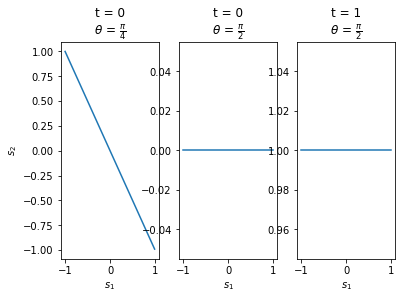

In [608]:
s1 = np.arange(-1,1,0.01)
i = 1
thetas = [np.pi/4, np.pi/2]
theta_names = [r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']
others = [0,1,1]
for t in [0,0,1]:
    theta = thetas[others[i-1]]
    print(theta)
    s2 = -1/np.tan(theta) * s1 + t/np.sin(theta)
    plt.subplot(1,3,i)
    plt.plot(s1,np.round(s2,4))
    plt.title("t = " + str(t) + "\n" + r'$\theta$ = ' + theta_names[others[i-1]])
    plt.xlabel(r'$s_1$')
    if i == 1:
        plt.ylabel(r'$s_2$')
    i += 1

## As can be seen in the above figure, $\theta$ changes the angle which the line makes with the axes and $t$ changes the shift in the $s_2$ direction. 
## $y(\theta,t)$ is the integration of the object along a line specified by the projection variables. The reason behind the line integral is that the impulse function given [here](#impulse_cell) zeroes out the whole function except for the line specified by the arguments of itself. 


# Q2 b

## Projection operation is defined as follows: $$ y(\theta,t) = \iint\limits_{-\infty}^{\infty} \delta(t - s_1\cos\theta - s_2\sin\theta) x(s_1,s_2) ds_1ds_2$$
## Using the given note that *_The adjoint of a general integral equation over an infinite domain is given by the same integral equation integrated with respect to the output variables._* adjoint of the projection operation can be defined as follows: 
$$ \begin{array}{ll}
  x(s_1,s_2) &= \int\limits_{\theta=0}^{\pi}\int\limits_{t=-\infty}^{\infty} \delta(t - s_1\cos\theta - s_2\sin\theta) y(\theta,t) d{\theta}dt \\ \\
    &= \int\limits_{\theta=0}^{\pi}y(\theta,s_1\cos\theta + s_2\sin\theta) d{\theta}dt
  \end{array} $$
## Physically this equation describes a procedure where projection matrix is integrated over a line described by $s_1, s_2$ and $\theta$ and the value of $x(s_1,s_2)$ is computed. This projection is known as back-projection. 

In [609]:
from skimage.transform import radon, resize
from skimage.data import camera, shepp_logan_phantom

# Q2 c

## $$ y(\theta,t) = \iint\limits_{-\infty}^{\infty} \delta(t - s_1\cos\theta - s_2\sin\theta) x(s_1,s_2) ds_1ds_2$$

### The matrix T that conducts discrete random transform operation is composed of elements $t_{ij}$'s representing the line integral of $i^{th}$ ray along the $j^{th}$ basis vector, _i.e._, $j^{th}$ pixel. In the given discretization scheme, the integral boundaries regarding $s1$ and $s_2$ directions can be found as follows: 
$$\begin{array}{ll}
s_1 &\in \ \ \ [\frac{N}{2}-i\bmod{N},\frac{N}{2}-i\bmod{N}-1] \\
s_2 &\in \ \ \ [\frac{-N}{2} + \lfloor j/N \rfloor,\frac{-N}{2} + \lfloor j/N \rfloor+1]
\end{array}$$

## In more analytical notation, $$b_j(s_1,s_2) = \Pi(s_1 - (\frac{N}{2} - 0.5 - i\bmod{N}), s_2 - (\frac{-N}{2} + 0.5 + \lfloor j/N \rfloor))$$ where $\Pi$ represent the rectangular function.
## Hence, entries of $T$ can be written as $$T_{ij} = y(\theta,t) = \int\limits_{s_1 = \frac{N}{2}-i\bmod{N}}^{\frac{N}{2}-i\bmod{N}-1} \int\limits_{s_2 = \frac{-N}{2} + \lfloor j/N \rfloor}^{\frac{-N}{2} + \lfloor j/N \rfloor+1} \delta(t - s_1\cos\theta - s_2\sin\theta) \underbrace{x(s_1,s_2)}_{=1} ds_1ds_2$$

## Soem example basis functions can be found below.


Text(0, 0.5, '$s_2$')

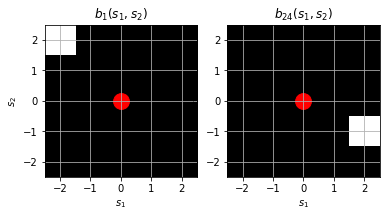

In [610]:
A = np.zeros((5,5))
A[0,0] = 1
plt.subplot(1,2,1)
plt.imshow(A,extent=[-A.shape[1]/2., A.shape[1]/2., -A.shape[0]/2., A.shape[0]/2. ],cmap="gray")
plt.grid()
plt.scatter(0,0,c="red",s=250)
plt.title(r'$b_1(s_1,s_2)$')
plt.xlabel(r'$s_1$')
plt.ylabel(r'$s_2$')
plt.subplot(1,2,2)
A[0,0] = 0
A[3,4] = 1
plt.title(r'$b_{24}(s_1,s_2)$')
plt.xlabel(r'$s_1$')
plt.xlabel(r'$s_2$')
plt.imshow(A,extent=[-A.shape[1]/2., A.shape[1]/2., -A.shape[0]/2., A.shape[0]/2. ],cmap="gray")
plt.grid()
plt.scatter(0,0,c="red",s=250)
plt.xlabel(r'$s_1$')
plt.ylabel(r'$s_2$')


# Q2 d

In [611]:
def projmtx(N, thetas):

    T = np.empty((int(np.ceil(N*np.sqrt(2))*len(thetas)),0))
    for i in range(N**2):
        row = np.mod(i,N)
        col = i//N
        basis_vec = np.zeros((N,N))
        basis_vec[row,col] = 1
        basis_vec_output = radon(basis_vec,thetas,circle=False)
        transformed_basis_vec = basis_vec_output.flatten(order="F")
        T = np.column_stack((T,transformed_basis_vec.flatten(order="F")))
    return T

[INFO] All tests are success!


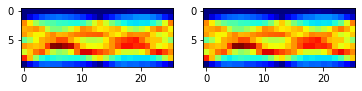

In [612]:
for _ in range(100): 
    N = np.random.randint(4,20,(1,1)).item()
    a = np.random.randint(1,100,(N,N))
    thetas = np.arange(0,180,N)
    T = projmtx(N,thetas)
    res = T.dot(a.flatten(order="F"))
    res = np.reshape(res,(res.shape[0],1))
    res2 = radon(a,thetas,circle=False, preserve_range=True)
    res = np.reshape(res,(res2.shape),order="F")
    assert np.sum(np.isclose(res,res2)) == res.size
    
print("[INFO] All tests are success!")
plt.subplot(1,2,1)
plt.imshow(res)
plt.subplot(1,2,2)
plt.imshow(res2)


# Q2 e

[INFO] All tests are success!


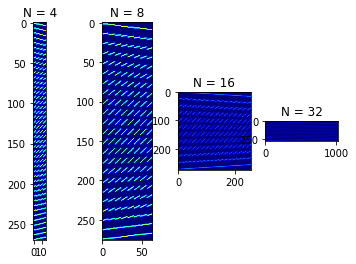

In [613]:
i = 1
for N in [1,4,8,16,32]:
    if not N == 1:
        X = resize(shepp_logan_phantom() ,(N,N))
    else:
        X = np.random.randint(1,100,(N,N))
    thetas = np.arange(0,180,N)
    T = projmtx(N,thetas)
    plt.subplot(1,4,i)
    plt.imshow(T)
    plt.title("N = " + str(N))
    if not N == 1:
        i += 1
    res = T.dot(X.flatten(order="F"))
    res = np.reshape(res,(res.shape[0],1))
    res2 = radon(X,thetas,circle=False, preserve_range=True)
    res = np.reshape(res,(res2.shape),order="F")
    assert np.sum(np.isclose(res,res2)) == res.size
print("[INFO] All tests are success!")

## Shepp-Logan and other random phantoms have the same projection via projection matrix and built in radon.
## The resultant matrices are not Toeplitz matrices, hence the transform is not shift invariant. 

# Q2 f
## Let A be the matrix representation of a linear system operator. Then the adjoint operator $A^*$ is defined as $A^T$.

Text(0.5, 1.0, 'Back projected Shepp Logan')

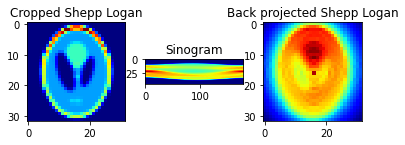

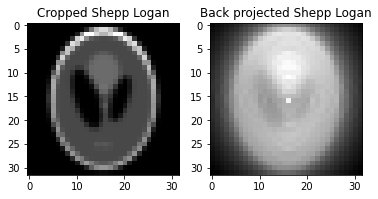

In [614]:
X = resize(shepp_logan_phantom() ,(N,N))
thetas = np.arange(0,180,1)
T = projmtx(N,thetas)
projections = radon(X,theta=thetas,circle=False,preserve_range=True)
back_projected_X = np.reshape(T.T.dot(projections.flatten(order="F")),X.shape,order="F")

plt.figure()
plt.subplot(1,3,1)
plt.imshow(X)
plt.title("Cropped Shepp Logan")
plt.subplot(1,3,2)
plt.imshow(projections)
plt.title("Sinogram")
plt.subplot(1,3,3)
plt.imshow(back_projected_X)
plt.title("Back projected Shepp Logan")

plt.figure()
plt.subplot(1,2,1)
plt.imshow(X,cmap="gray")
plt.title("Cropped Shepp Logan")
plt.subplot(1,2,2)
plt.imshow(back_projected_X,cmap="gray")
plt.title("Back projected Shepp Logan")


##  The remaining questions are implemented in MATLAB. 